In [ ]:
import math, random, numpy as np
from typing import Dict, List, Tuple, Optional

# ------------------------------------------------------------------ #
#  Input-matrix → shape dictionary  (same helper as before)          #
# ------------------------------------------------------------------ #
ShapeInfo = Dict[str, object]

def extract_shapes(mat: List[List[int]]) -> Dict[int, ShapeInfo]:
    shapes: Dict[int, ShapeInfo] = {}
    for r, row in enumerate(mat):
        for c, k in enumerate(row):
            if k:
                shapes.setdefault(k, []).append((r, c))
    for k, abs_cells in shapes.items():
        min_r = min(r for r, _ in abs_cells)
        min_c = min(c for _, c in abs_cells)
        rel   = [(r - min_r, c - min_c) for r, c in abs_cells]
        h     = max(r for r, _ in rel) + 1
        w     = max(c for _, c in rel) + 1
        shapes[k] = dict(cells=rel, h=h, w=w, area=len(rel))
    print(shapes)
    return shapes

# ------------------------------------------------------------------ #
#  fitness & a board builder                                           #
# ------------------------------------------------------------------ #
def build_board(anchors, shape_list, S):
    ## blank board 
    board = np.zeros((S, S), int)
    bad   = 0
    for (r0, c0), (k, sh) in zip(anchors, shape_list):
        for dr, dc in sh["cells"]:
            r, c = r0 + dr, c0 + dc

            ## cell out of bounds ?? 
            if r < 0 or r >= S or c < 0 or c >= S:
                bad += 1  

            ## cell already occupied ?? 
            elif board[r, c]:
                bad += 1
            else:
                board[r, c] = k
    return board, bad

def fitness(anchors, shape_list, S):
    _, bad = build_board(anchors, shape_list, S)
    if bad == 0:
        return 0.0
    return 1000 + bad

# ------------------------------------------------------------------ #
#  tabu Search for a fixed square side                               #
# ------------------------------------------------------------------ #
def tabu_side(shape_list,
              S,
              iters=600,
              tabu_tenure=7,
              neigh_size=40,
              seed: Optional[int] = None):

    rnd = random.Random(seed)
    n_shapes = len(shape_list)

    # ----- initial random anchors (legal bounding-box placement) -----
    anchors = [ (rnd.randint(0, S - sh["h"]),
                 rnd.randint(0, S - sh["w"])) for _, sh in shape_list ]
    best_anchors = anchors.copy()
    best_fit     = fitness(anchors, shape_list, S)

    # tabu list  :  dict { (shape_idx, old_anchor) : expire_iter }
    tabu: Dict[Tuple[int, Tuple[int,int]], int] = {}

    for it in range(1, iters + 1):
        best_move   = None
        best_move_f = float('inf')

        # ------- neighbourhood sampling -------
        for _ in range(neigh_size):
            i = rnd.randrange(n_shapes)                 # pick a shape
            k, sh = shape_list[i]
            r_new = rnd.randint(0, S - sh["h"])
            c_new = rnd.randint(0, S - sh["w"])
            if (r_new, c_new) == anchors[i]:
                continue

            trial = anchors.copy()
            trial[i] = (r_new, c_new)
            f = fitness(trial, shape_list, S)

            is_tabu = (i, anchors[i]) in tabu and tabu[(i, anchors[i])] > it
            if is_tabu and f >= best_fit:
                continue        # tabu & not aspiring

            if f < best_move_f:
                best_move   = (i, (r_new, c_new))
                best_move_f = f

        if best_move is None:
            break  # no legal moves sampled (rare)

        # ----- apply best move -----
        i, new_pos = best_move
        old_pos    = anchors[i]
        anchors[i] = new_pos

        tabu[(i, old_pos)] = it + tabu_tenure
        if best_move_f < best_fit:
            best_fit, best_anchors = best_move_f, anchors.copy()
            if best_fit == 0:
                return True, best_anchors

    return False, best_anchors

# ------------------------------------------------------------------ #
#  Search smallest S                                                 #
# ------------------------------------------------------------------ #
def tabu_pack_smallest(mat,
                       iters=600,
                       neigh=40,
                       tabu_tenure=7,
                       restarts=3):

    shapes      = extract_shapes(mat)
    shape_list  = sorted(shapes.items(), key=lambda kv: -kv[1]["area"])
    area        = sum(sh["area"] for sh in shapes.values())
    S_min       = math.ceil(math.sqrt(area))
    S_max       = max(len(mat), len(mat[0]))
    
    for S in range(S_min, S_max + 1):
        for r in range(restarts):
            ok, anchors = tabu_side(shape_list, S,
                                    iters=iters,
                                    tabu_tenure=tabu_tenure,
                                    neigh_size=neigh,
                                    seed=r)
            if ok:
                board, _ = build_board(anchors, shape_list, S)
                placement = {k: pos for (k, _), pos in zip(shape_list, anchors)}
                return S, board, placement
    raise RuntimeError(f"Tabu-search failed up to side {S_max}")

# ------------------------------------------------------------------ #
  #                                                 #
# ------------------------------------------------------------------ #
#
#     matrix = [
#         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#         [0,1,1,0,0,0,2,2,0,3,3,3,3,0,0,0,0,0,0,0],
#         [0,0,1,1,0,0,2,2,0,0,3,3,3,0,4,0,0,0,0,0],
#         [0,0,1,1,0,0,2,2,0,0,3,3,3,0,4,0,0,4,4,0],
#         [0,0,0,0,0,0,2,2,2,0,3,3,3,0,4,0,0,4,4,0],
#         [0,0,0,0,0,0,2,2,2,0,0,0,0,0,4,0,0,4,4,0],
#         [0,0,0,0,0,0,0,0,0,0,0,5,5,0,4,0,4,4,4,0],
#         [0,6,6,6,6,6,6,6,6,6,0,5,5,0,4,4,4,4,4,0],
#         [0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0],
#         [0,0,0,0,0,5,5,5,5,5,5,5,5,0,7,7,7,7,0,0],
#         [0,0,0,0,0,5,5,5,5,5,5,5,5,0,7,7,7,7,0,0],
#         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,0,0],
#         [0,9,9,9,9,9,9,9,0,0,8,8,0,0,7,7,7,7,0,0],
#         [0,9,9,9,9,9,9,9,0,0,8,8,0,0,7,7,7,7,0,0],
#         [0,9,9,0,0,0,9,9,0,0,8,8,0,0,0,0,0,0,0,0],
#         [0,0,0,0,0,0,9,9,0,0,8,8,8,8,8,8,0,0,0,0],
#         [0,0,0,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#         [0,0,0,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#     ]

#     S, board, place = tabu_pack_smallest(matrix,
#                                          iters=500,
#                                          neigh=30,
#                                          tabu_tenure=6,
#                                          restarts=2)

#     print(f"✔ Tabu-search packed into {S}×{S}")
#     for k, (r, c) in sorted(place.items()):
#         print(f"Shape {k:2d} at ({r:2d},{c:2d})")


{1: {'cells': [(0, 0), (0, 1), (1, 1), (1, 2), (2, 1), (2, 2)], 'h': 3, 'w': 3, 'area': 6}, 2: {'cells': [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2)], 'h': 5, 'w': 3, 'area': 12}, 3: {'cells': [(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 'h': 4, 'w': 4, 'area': 13}, 4: {'cells': [(0, 0), (1, 0), (1, 3), (1, 4), (2, 0), (2, 3), (2, 4), (3, 0), (3, 3), (3, 4), (4, 0), (4, 2), (4, 3), (4, 4), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4)], 'h': 6, 'w': 5, 'area': 19}, 5: {'cells': [(0, 6), (0, 7), (1, 6), (1, 7), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7)], 'h': 5, 'w': 8, 'area': 22}, 6: {'cells': [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)], 'h': 1, 'w': 9, 'area': 9}, 7: {'cells': [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2,

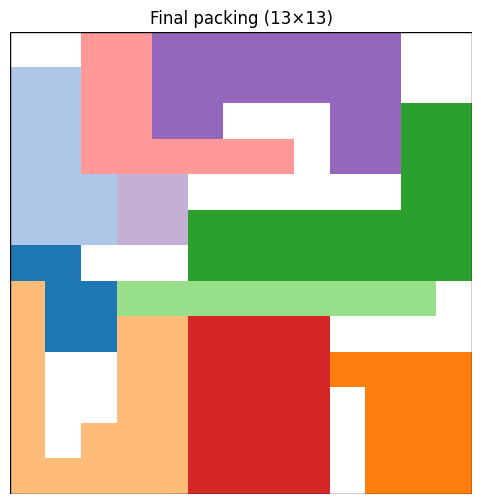

In [5]:
"""
Print and visualise the final packing returned by the Tabu-Search solver
(tabu_pack_smallest).  Assumes the solver code has already been defined
in the same file or imported as a module.
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
# -------------------------------------------------------------
# 1. Tabu-Search packer (uses low-cost parameters)
# -------------------------------------------------------------
matrix = [
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,1,0,0,0,2,2,0,3,3,3,3,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,2,2,0,0,3,3,3,0,4,0,0,0,0,0],
    [0,0,1,1,0,0,2,2,0,0,3,3,3,0,4,0,0,4,4,0],
    [0,0,0,0,0,0,2,2,2,0,3,3,3,0,4,0,0,4,4,0],
    [0,0,0,0,0,0,2,2,2,0,0,0,0,0,4,0,0,4,4,0],
    [0,0,0,0,0,0,0,0,0,0,0,5,5,0,4,0,4,4,4,0],
    [0,6,6,6,6,6,6,6,6,6,0,5,5,0,4,4,4,4,4,0],
    [0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0],
    [0,0,0,0,0,5,5,5,5,5,5,5,5,0,7,7,7,7,0,0],
    [0,0,0,0,0,5,5,5,5,5,5,5,5,0,7,7,7,7,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,0,0],
    [0,9,9,9,9,9,9,9,0,0,8,8,0,0,7,7,7,7,0,0],
    [0,9,9,9,9,9,9,9,0,0,8,8,0,0,7,7,7,7,0,0],
    [0,9,9,0,0,0,9,9,0,0,8,8,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,9,9,0,0,8,8,8,8,8,8,0,0,0,0],
    [0,0,0,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
]


start = time.time()

side, board, placements = tabu_pack_smallest(
    matrix,
    iters=500,      # iterations per restart
    neigh=30,       # neighbourhood samples
    tabu_tenure=6,  # tabu list length
    restarts=2      # independent runs
)

end = time.time()
elapsed = end - start
print(f"\n⏱️ Tabu Search completed in {elapsed:.3f} seconds")
# run the Tabu-Search with modest parameters

# -------------------------------------------------------------
# 2.  Print the final placement matrix
# -------------------------------------------------------------
print(f"\nPacked into {side}×{side} square")
print(np.array(board))          # as NumPy array
# Or:  print(board.tolist())    # plain Python list-of-lists

print("\nTop-left anchors:")
for k, (r, c) in sorted(placements.items()):
    print(f"  shape {k:2d} → ({r:2d}, {c:2d})")

# -------------------------------------------------------------
# 3.  Visualise with white background & grid
# -------------------------------------------------------------
tab20 = plt.cm.tab20
col   = tab20(np.linspace(0, 1, 20))
col   = np.vstack(([1, 1, 1, 1], col))     # prepend white for 0s
cmap  = mcolors.ListedColormap(col)
norm  = mcolors.BoundaryNorm(range(22), cmap.N)

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.imshow(board, cmap=cmap, norm=norm)

ax.plot([-.5, side - .5], [-.5, -.5], color="black", linewidth=1.0)  # top
ax.plot([-.5, side - .5], [side - .5, side - .5], color="black", linewidth=1.0)  # bottom
ax.plot([-.5, -.5], [-.5, side - .5], color="black", linewidth=1.0)  # left
ax.plot([side - .5, side - .5], [-.5, side - .5], color="black", linewidth=1.0)

ax.set_title(f"Final packing ({side}×{side})")
#plt.colorbar(cax, ax=ax)
ax.axis("off")
plt.show()
